In [1]:
#Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(6666)

#Getting the given data
train_df = pd.read_csv('d_reg_tra.txt', sep='\n', header=None)
val_df = pd.read_csv('d_reg_val.txt',sep='\n', header=None)

X_train, y_train = [], []
X_val, y_val = [], []
for i in train_df[0]:
  x,y = float(i.split()[0]), float(i.split()[1])
  X_train.append(x)
  y_train.append(y)

for i in val_df[0]:
  x,y = float(i.split()[0]), float(i.split()[1])
  X_val.append(x)
  y_val.append(y)

X_train, y_train, X_val, y_val = np.array(X_train), np.array(y_train), np.array(X_val), np.array(y_val)

# **RBFNET**

In [2]:
class RBF():
    def __init__(self, k,epochs ,lr=0.01):
        self.k = k
        self.lr = lr
        self.epochs = epochs
        self.w = np.random.randn(k)
        self.b = np.random.randn(1)

    def gaussian(self ,x, center, sig):
        return np.exp((-1 / (2 * sig ** 2)) * (x - center) ** 2)

    def sig_finder(self,clusters,X,k):
        '''
            computing spreads of clusters
            finding clusters with 1 or 0 points and compute their spreads as mean of others` spreads
        '''
        sigma = np.zeros(k)
        ideal_cluster = np.argmin(np.squeeze(np.abs(X[:, np.newaxis] - clusters[np.newaxis, :])), axis=1)
        averg = []
        outliers = []
        for i in range(k):
            pointsForCluster = X[ideal_cluster == i]
            if len(pointsForCluster) < 2:
                outliers.append(i)
            else:
                averg.append(X[ideal_cluster == i])
                sigma[i] = np.std(X[ideal_cluster == i])
        averg = np.concatenate(averg)
        sigma[outliers] = np.mean(np.std(averg))
        return sigma

    def clustering(self ,X, k):
        ''' uniform setting of initial centers '''
        lx = len(X)
        diff = lx / k
        o = []
        for i in range(0, k):
            o.append(X[int(diff * i)])
        clusters = np.array(o)
        ''' random choice of initial centers '''
        # clusters = np.random.choice(np.squeeze(X), size=k)
        before = clusters.copy()
        flag = True
        while flag:
            '''find the cluster that's closest to each point'''
            ideal_cluster = np.argmin(np.squeeze(np.abs(X[:, np.newaxis] - clusters[np.newaxis, :])), axis=1)
            '''updating each cluster by taking the mean of all of the points in it'''
            for i in range(k):
                Numbers = X[ideal_cluster == i]
                if len(Numbers) > 0:
                    clusters[i] = np.mean(Numbers, axis=0)
            flag = np.average(clusters - before) > 0.000001
            before = clusters.copy()
        sigma = self.sig_finder(clusters,X,k)
        return clusters, sigma

    def fit(self, X, y):
        self.centers, self.stds = self.clustering(X, self.k)
        for epoch in range(self.epochs):
            self.sig_list = []
            self.w_h_p_h = []
            for i in range(len(X)):
                # forward pass
                self.sig=np.array(self.gaussian(X[i], self.centers, self.stds))
                self.sig_list.append(self.sig)
                Y = np.dot(self.sig,self.w) + self.b
                self.w_h_p_h.append(np.dot(self.sig,self.w))
                # backward pass
                error = -(y[i] - Y)
                self.w = self.w - self.lr * self.sig * error
                self.b = self.b - self.lr * error
            self.sig_list = np.array(self.sig_list)
            self.w_h_p_h = np.array(self.w_h_p_h)

    def predict(self, X):
        y_pred = []
        for i in range(len(X)):
            sig = np.array(self.gaussian(X[i], self.centers, self.stds))
            Y = sig.dot(self.w) + self.b
            y_pred.append(Y)
        return np.array(y_pred)

- H: Hidden neuron number = COUNT(cluster)
- p_H(RBF) = hidden neuron values after the multiplying with the corresponding rates(Gaussian)
- w_h*p_h = weighted values

## **Part 1**

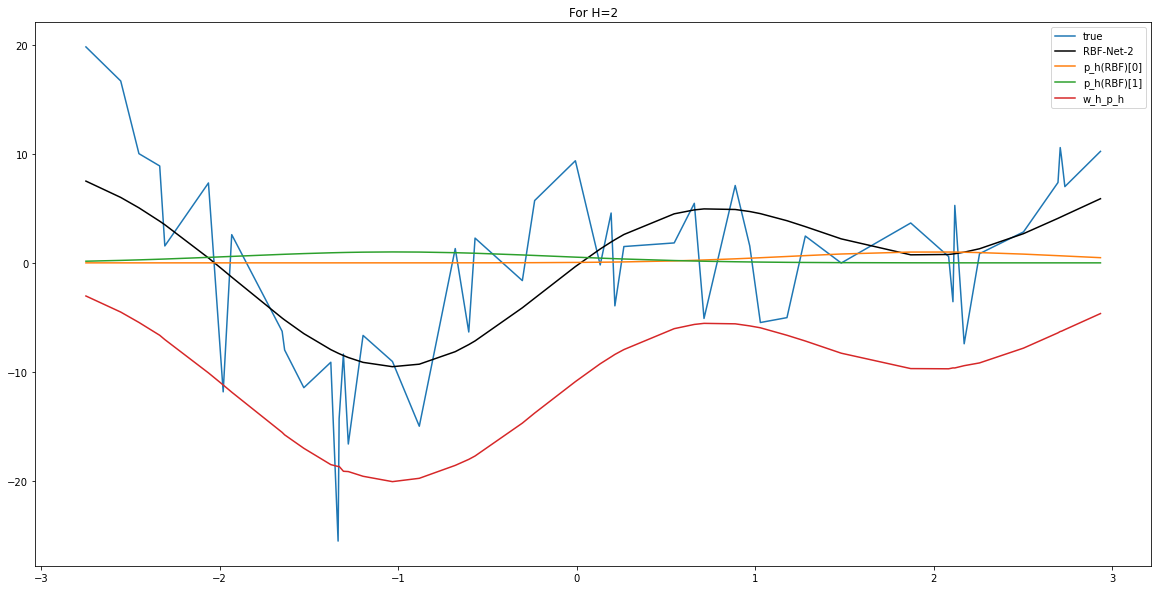

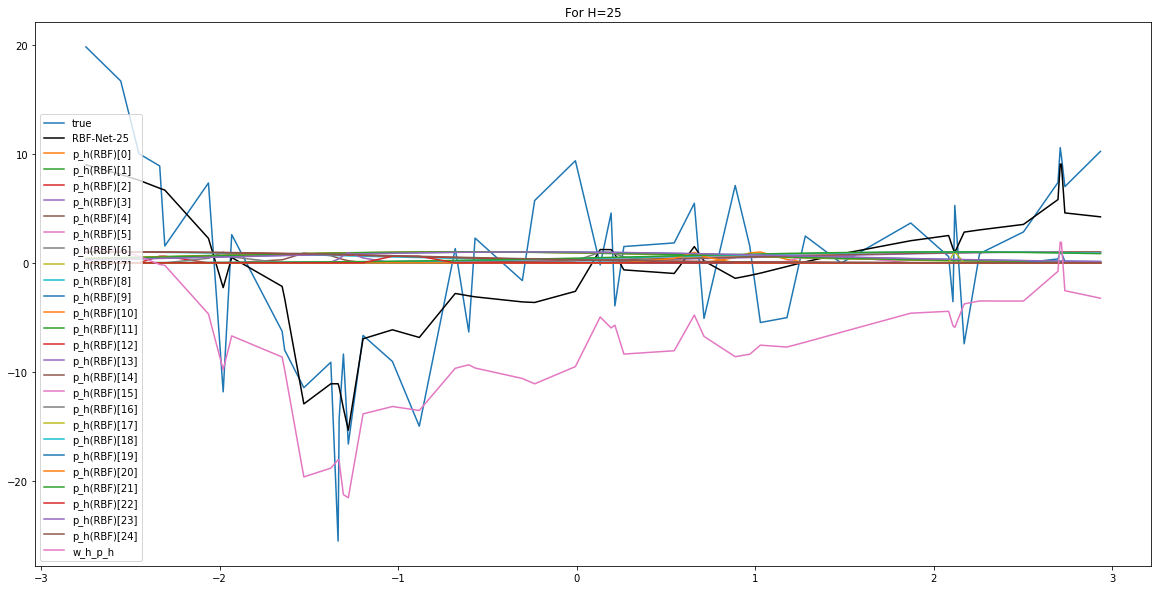

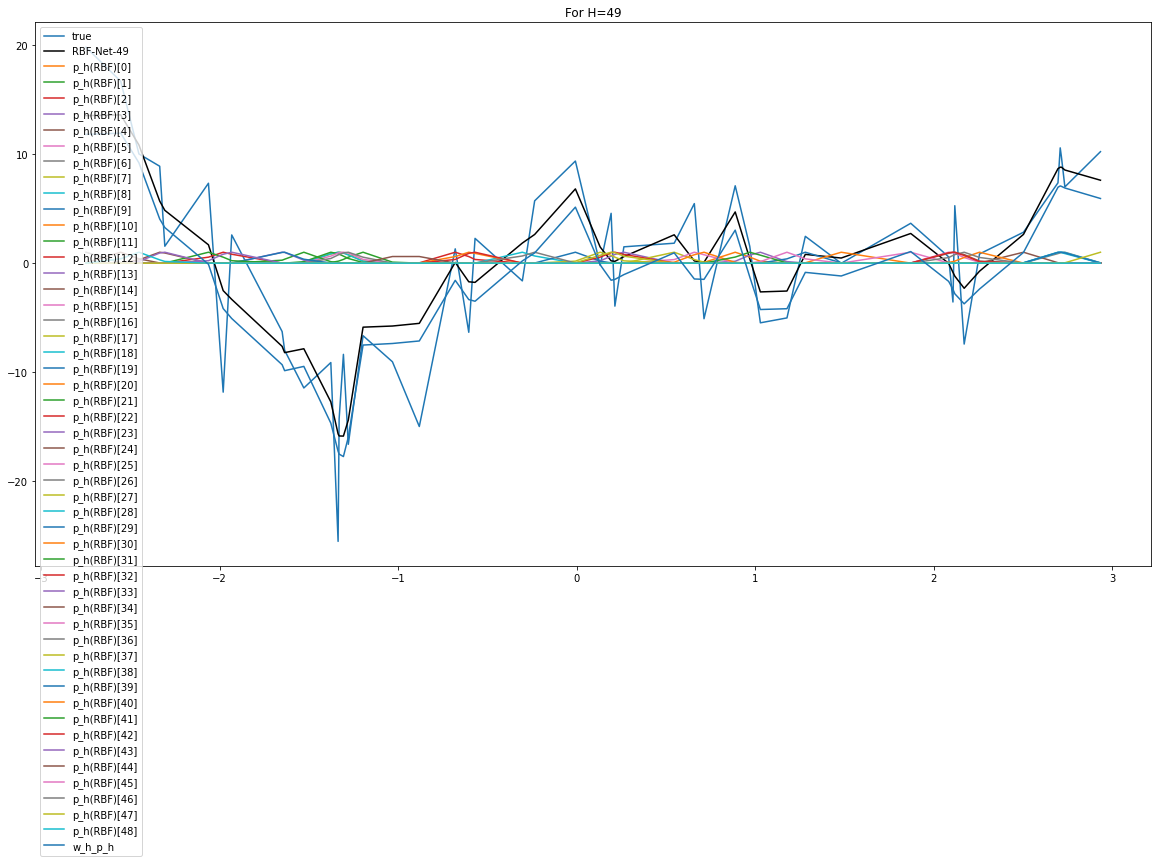

In [3]:
H_list = [2, 25, 49]  #####   2 = underfit,25 = fitting, 49 = overfitting

for H in H_list:
  rbfnet = RBF(k=H, epochs=100)
  rbfnet.fit(X_train, y_train)
  y_pred = rbfnet.predict(X_train)

  predictions = pd.DataFrame()
  predictions['X_train'] = X_train
  predictions['y_train'] = y_train
  predictions['y_pred'] = y_pred
  for i in range(H):
    predictions['p_h(RBF)[{i}]'.format(i=i)] = np.hsplit(rbfnet.sig_list,H)[i]
  predictions['w_h_p_h'] = rbfnet.w_h_p_h

  sorted_predictions = predictions.sort_values(by=['X_train'])

  plt.figure(figsize=(20,10))
  plt.plot(sorted_predictions['X_train'],sorted_predictions['y_train'], label='true')
  plt.plot(sorted_predictions['X_train'], sorted_predictions['y_pred'], color='black', label='RBF-Net-{H}'.format(H=H))
  for i in range(H):
    plt.plot(sorted_predictions['X_train'],sorted_predictions['p_h(RBF)[{i}]'.format(i=i)], label='p_h(RBF)[{i}]'.format(i=i))
  plt.plot(sorted_predictions['X_train'],sorted_predictions['w_h_p_h'], label='w_h_p_h')
  plt.legend()
  plt.title('For H={i}'.format(i=H))
  plt.show()

## **Part-2**

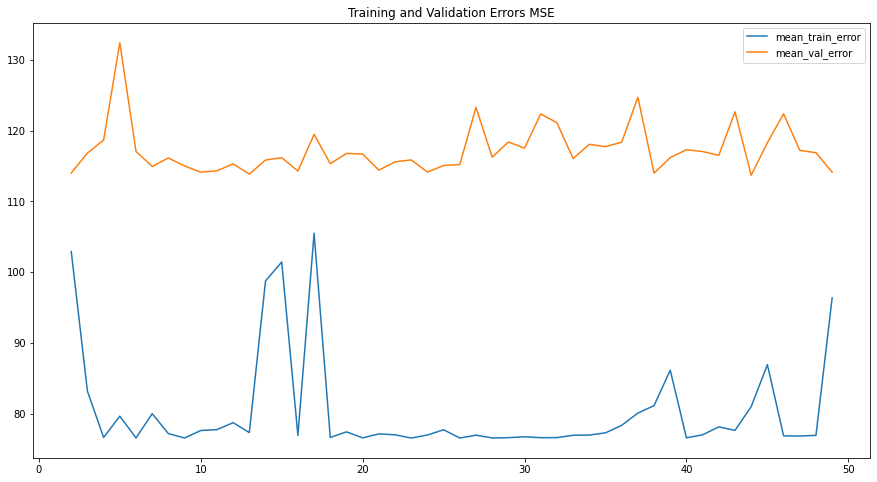

In [4]:
train_error_list = []
val_error_list = []
for H in range(2,50):
  train_errors = []
  val_errors = []
  for _ in range(10):
    rbfnet = RBF(k=H, epochs=100) #random initiallization
    rbfnet.fit(X_train, y_train)
    y_train_pred = rbfnet.predict(X_train)
    y_val_pred = rbfnet.predict(X_val)
    train_error = y_train - y_train_pred
    val_error = y_val - y_val_pred
    train_errors.append(train_error[0])
    val_errors.append(val_error[0])
  mean_train_error = np.array(train_errors).mean(0) #Taking average error
  mean_val_error = np.array(val_errors).mean(0) #Taking average error

  mse_train = (np.array(mean_train_error)**2).sum()/len(X_train)
  mse_val = (np.array(mean_val_error)**2).sum()/len(X_val)
  train_error_list.append(mse_train)
  val_error_list.append(mse_val)
    
plt.figure(figsize=(15,8))
plt.plot(range(2,50), train_error_list, label='mean_train_error')
plt.plot(range(2,50), val_error_list, label='mean_val_error')
plt.legend()
plt.title('Training and Validation Errors MSE'.format(i=H))
plt.show()

## **Result**

For this task, first we clustered the data with KMeans algorithm then we feed the RBF neural network with gaussian function using clustering data. We run our model with learning rate 0.01 and epoch=100,we randomly initialized our weights and cluster centers, we used online gradient descent to update our model's weights. We choosed hidden neuron number with cluster count. From the above figure, we can see the errors(MSE) by cluster counts. We saw that for 2-clusters our model is underfitting, for 25-clusters our model is good-fitting, for 49-clusters our model is overfitting. Our regression results are not perfect. We can optimize our model with more layer or more data/feature or more complexed model.